Описание: 
- Хотим предсказывать выход в просроченный платеж пользователей. Таргет - 1 - вышел, 0 - не вышел

Задачи:
1. улучшить качество модели от baseline
2. добавление факторов аргументируйте визуализацией и комментарием в коде
3. сделать кросс валидацию с перемешиванием для оценки итогового результата StratifiedShuffleSplit, разбиение на 5 фолдов
4. качество оценивать по roc auc и выведете средний результат по 5 фолдам. Данный результат выведите в коде и запишите в итоговую анкету как ответ к Заданию 1.
5. напишите 3-5 действий по итогу оценки качества, которые Вы бы сделали для улучшения качества модели, если бы Вам дали на работу еще 5 рабочих дней. Ответ напишите в комментариях к коду в конце.

Также у организаторов были получены описания каждого из признаков, и мной были предположены типы каждого из них:

1. age - возраст (Целочисленный)
2. job - работа (Категориальный: admin., technician, management, unknown, unemployed, blue-collar, housemaid, self-employed, entrepreneur, services, retired, student)
3. marital - статус в браке (Категориальный: unknown, married, divorced, single)
4. education - образование (Категориальный: high.school, professional.course, university.degree, basic.6y, unknown, basic.9y, basic.4y)
5. default - были ли ранее признаки дефолта (Категориальный: no, unknown)
6. housing - наличие своей недвижимости (Категориальный: yes, no, unknown)
7. loan - наличие открытого кредита (Категориальный: no, unknown, yes)
8. contact - тип предпочтительной связи (Категориальный: cellular, telephone)
9. month - месяц взятия кредита (Категориальный: may, jun, nov, sep, jul, aug, mar, oct, apr, dec)
10. day_of_week - день взятия кредита (Категориальный: fri, wed, mon, thu, tue)
11. duration - срок в днях на который взят кредит (Целочисленный)
12. campaign - идентификатор маркетинговой компании привлечения (Раз это идентификатор, то скорее всего категориальный: 2, 4, 1, 3, 6, 7, 27, 5, 12, 14, 10, 8, 11, 13, 9, 15, 16, 18, 17, 22, 19, 23, 24, 35)
13. pdays - суммарное количество дней просрочки платежа ранее (999 значит неизвестно) (Целочисленный)
14. previous - количество ранее выданных кредитов (Целочисленный)
15. poutcome - результат связи по типу связи (Категориальный: nonexistent, failure, success)
16. emp.var.rate - относительный показатель работы (Вещественный)
17. cons.price.idx - относительный показатель удовлетворенности цены (Вещественный)
18. cons.conf.idx - относительный показатель результатов анкетирования (Вещественный)
19. euribor3m - относительный показатель скорости взятия кредита (Вещественный)
20. nr.employed - относительный показатель времени работы (Вещественный)

Условимся последние 5 признаков считать вещественными, несмотря на то, что они имеют ограниченный набор значений.

In [18]:
import pandas as pd 
from sklearn.model_selection import train_test_split 

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score

In [2]:
# Считываем данные
data = pd.read_csv('train.csv')
data['y'] = data['y'].map({'no': 0, 'yes': 1})

**Рассмотрим каждый из признаков подробнее**

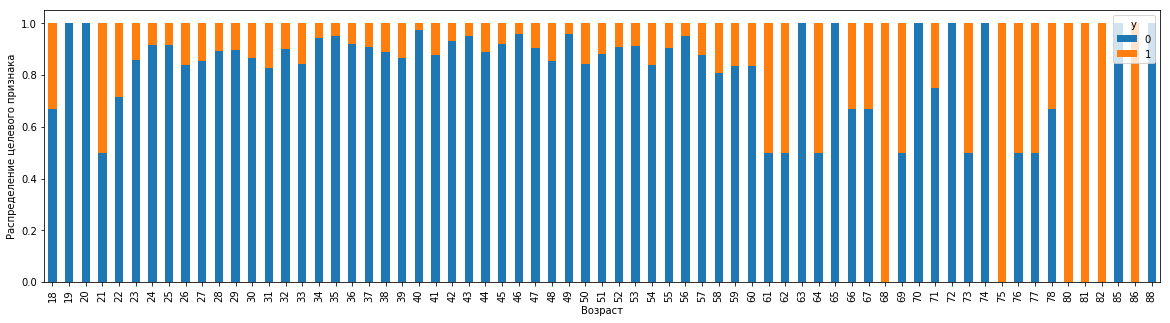

In [336]:
# Присутствует связь возраста и целевого признака
# Столь неоднородное распределение признака связанно в первую очередь с малым количеством наблюдений
# Но игнорировать его мы тоже не можем
age_table = pd.crosstab(data['age'], data['y'])
age_table.div(age_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Возраст');
plt.ylabel('Распределение целевого признака');

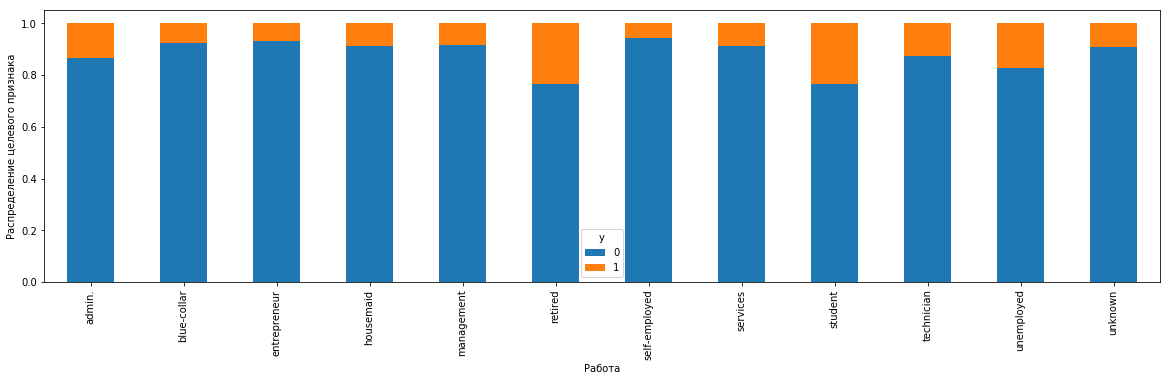

In [185]:
# Присутствует связь работы и целевого признака
# Так, например, самозанятые и офисные работники чаще возвращают кредит вовремя, нежели студенты или техники
job_table = pd.crosstab(data['job'], data['y'])
job_table.div(job_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Работа');
plt.ylabel('Распределение целевого признака');

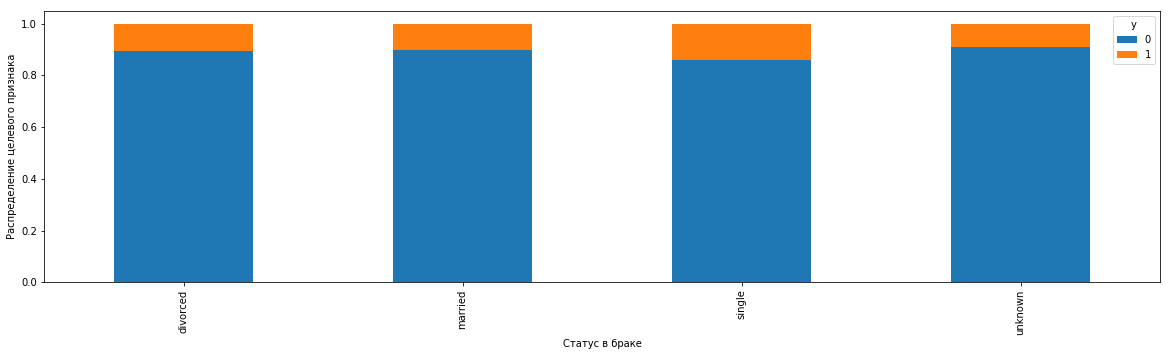

In [188]:
# Как можно наблюдать, люди с различным статусом в браке выходят в просрочку примерно равномерно 
marital_table = pd.crosstab(data['marital'], data['y'])
marital_table.div(marital_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Статус в браке');
plt.ylabel('Распределение целевого признака');

In [193]:
# Также приведем процент просрочивших кредит, по этим 4 категориям
# На основании этого можно заявлять, что статус в браке не будет качественным фактором для предсказания целевого
pd.crosstab(data['marital'], data['y'])[1] / pd.crosstab(data['marital'], data['y'])[0] * 100

marital
divorced    11.803279
married     11.136235
single      16.494845
unknown     10.000000
dtype: float64

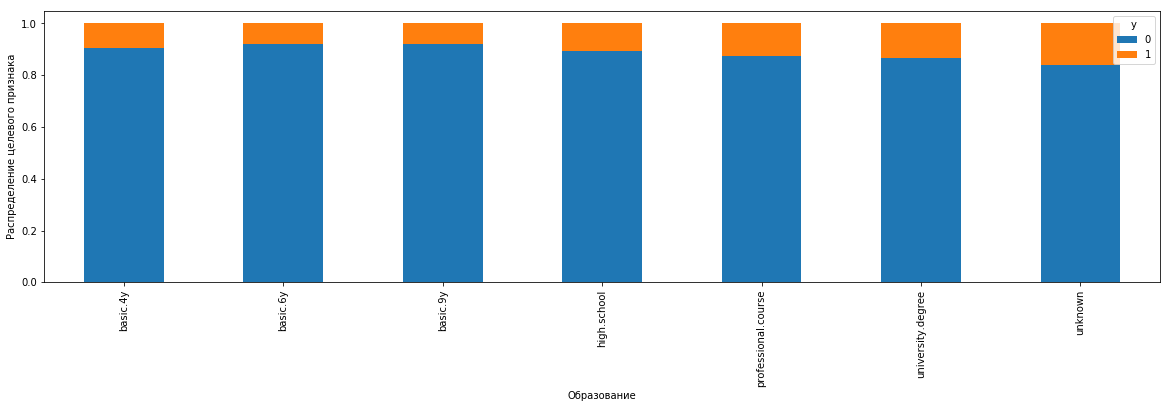

In [195]:
# Какой-либо серьезный разброс у уровня образования мы заметить не можем
# Не думаю, что данный предиктор стоит добавлять в модель
education_table = pd.crosstab(data['education'], data['y'])
education_table.div(education_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Образование');
plt.ylabel('Распределение целевого признака');

Признак default имеет лишь два значения: нет и неизвестно. По моему мнению это не несет какой-либо смысловой нагрузки и добавлять данный предиктор в модель не стоит.

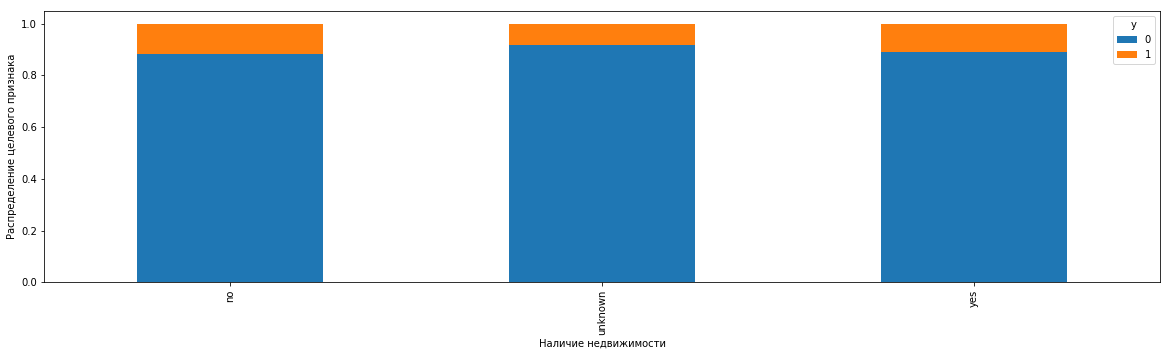

In [201]:
# Как можно заметить, наличие собственной недвижимости не имеет особого значения 
housing_table = pd.crosstab(data['housing'], data['y'])
housing_table.div(housing_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Наличие недвижимости');
plt.ylabel('Распределение целевого признака');

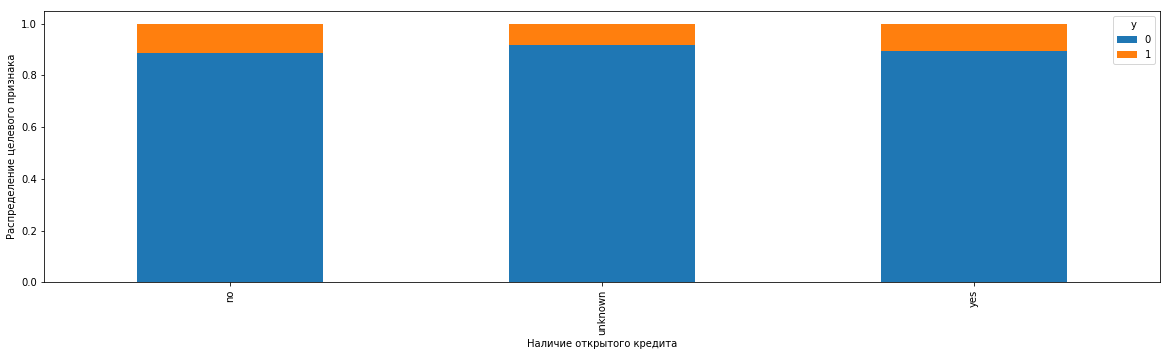

In [205]:
# Как и наличие открытого кредита
loan_table = pd.crosstab(data['loan'], data['y'])
loan_table.div(loan_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Наличие открытого кредита');
plt.ylabel('Распределение целевого признака');

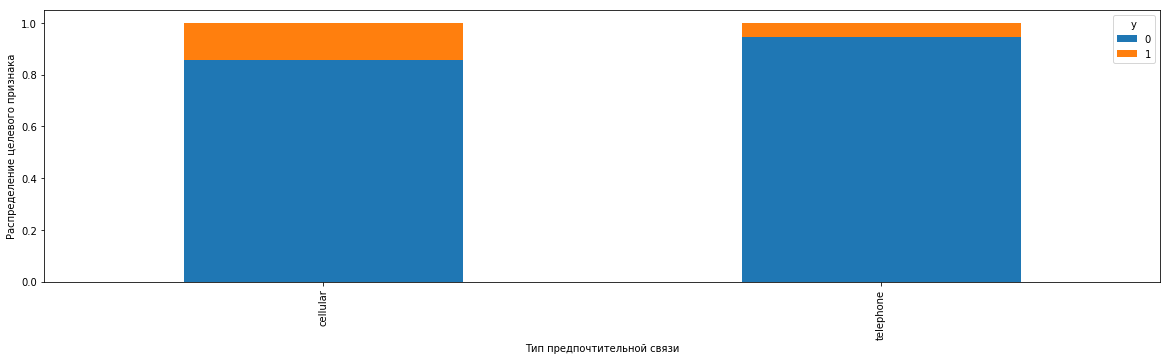

contact
cellular     16.770186
telephone     5.968779
dtype: float64


In [211]:
# Люди, с которыми связываются по мобильному телефону примерно в 3 раза меньше уходят в просрочку
# Стоит добавить данный предиктор в модель
contact_table = pd.crosstab(data['contact'], data['y'])
contact_table.div(contact_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Тип предпочтительной связи');
plt.ylabel('Распределение целевого признака');
print(pd.crosstab(data['contact'], data['y'])[1] / pd.crosstab(data['contact'], data['y'])[0] * 100)

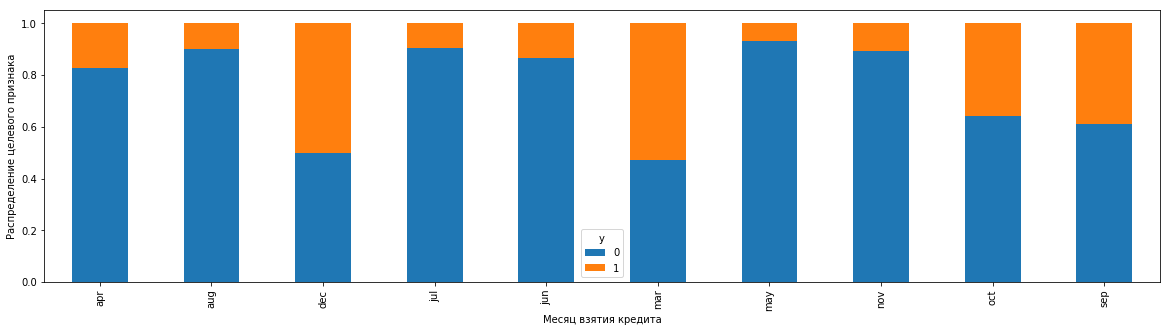

month
apr     21.052632
aug     11.009174
dec    100.000000
jul     10.371820
jun     15.492958
mar    111.764706
may      7.295720
nov     12.091503
oct     55.882353
sep     63.636364
dtype: float64


In [215]:
# Месяц взятия кредита существенно влияет на просрочку
# Стоит добавить данный предиктор в модель
month_table = pd.crosstab(data['month'], data['y'])
month_table.div(month_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Месяц взятия кредита');
plt.ylabel('Распределение целевого признака');
print(pd.crosstab(data['month'], data['y'])[1] / pd.crosstab(data['month'], data['y'])[0] * 100)

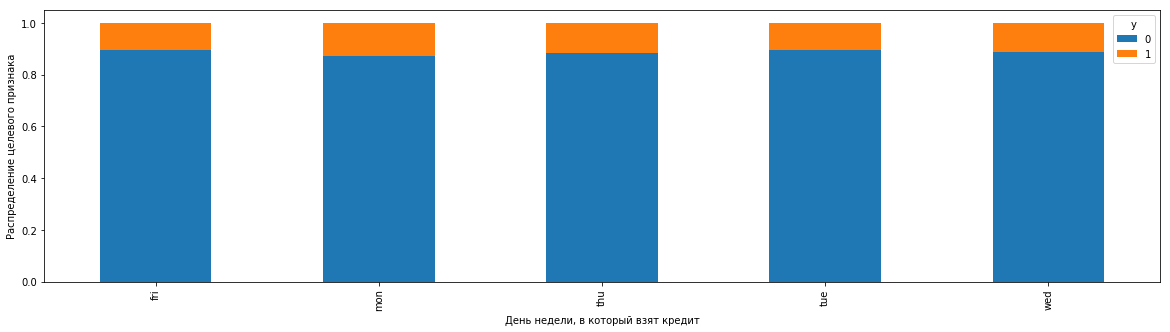

In [218]:
# А вот день недели, не оказывает никакого значения
day_of_week_table = pd.crosstab(data['day_of_week'], data['y'])
day_of_week_table.div(day_of_week_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('День недели, в который взят кредит');
plt.ylabel('Распределение целевого признака');

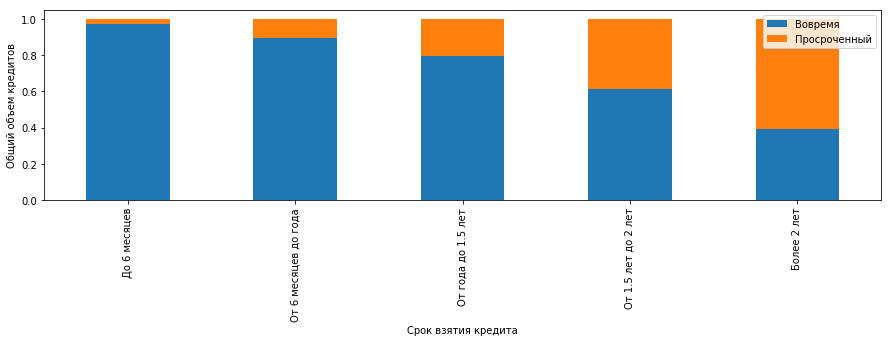

In [331]:
# Для анализа выделим различные продолжительности взятия кредита
# И обнаружим, что данный признак влияет существенно
cross_duration_y = pd.crosstab(data['duration'], data['y'])
duration_table = pd.DataFrame(columns = ['Вовремя', 'Просроченный'])
temp_table = cross_duration_y.loc[(0 <= cross_duration_y.index) & (cross_duration_y.index <= 186)]
duration_table.loc['До 6 месяцев'] = [temp_table.iloc[:, 0].sum(), temp_table.iloc[:, 1].sum()]
temp_table = cross_duration_y.loc[(187 <= cross_duration_y.index) & (cross_duration_y.index <= 372)]
duration_table.loc['От 6 месяцев до года'] = [temp_table.iloc[:, 0].sum(), temp_table.iloc[:, 1].sum()]
temp_table = cross_duration_y.loc[(373 <= cross_duration_y.index) & (cross_duration_y.index <= 558)]
duration_table.loc['От года до 1.5 лет'] = [temp_table.iloc[:, 0].sum(), temp_table.iloc[:, 1].sum()]
temp_table = cross_duration_y.loc[(559 <= cross_duration_y.index) & (cross_duration_y.index <= 744)]
duration_table.loc['От 1.5 лет до 2 лет'] = [temp_table.iloc[:, 0].sum(), temp_table.iloc[:, 1].sum()]
temp_table = cross_duration_y.loc[745 <= cross_duration_y.index]
duration_table.loc['Более 2 лет'] = [temp_table.iloc[:, 0].sum(), temp_table.iloc[:, 1].sum()]

duration_table.div(duration_table['Вовремя']+duration_table['Просроченный'], axis=0) \
    .plot(kind='bar', stacked=True, figsize=(15, 3.5));
plt.xlabel('Срок взятия кредита');
plt.ylabel('Общий объем кредитов');

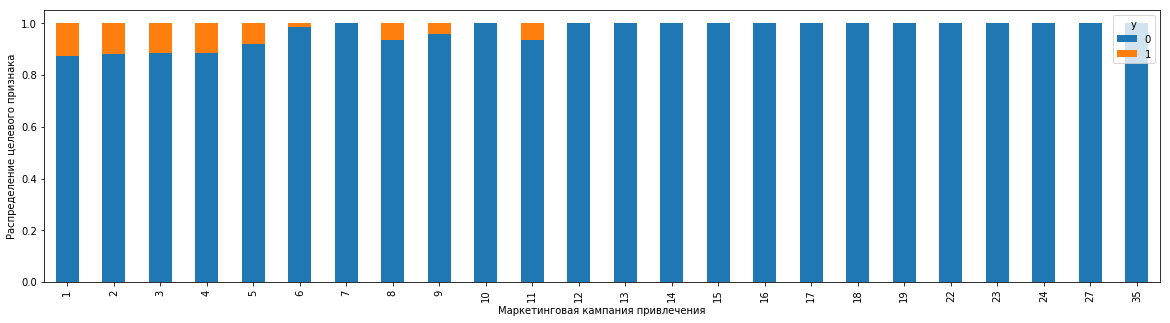

In [335]:
# Существуют маркетинговые капмпании, в которых нет просрочки ни у кого
# А так же те, в которые попадают люди с просроченным кредитом
# Стоит добавить данный признак в модель
campaign_table = pd.crosstab(data['campaign'], data['y'])
campaign_table.div(campaign_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Маркетинговая кампания привлечения');
plt.ylabel('Распределение целевого признака');

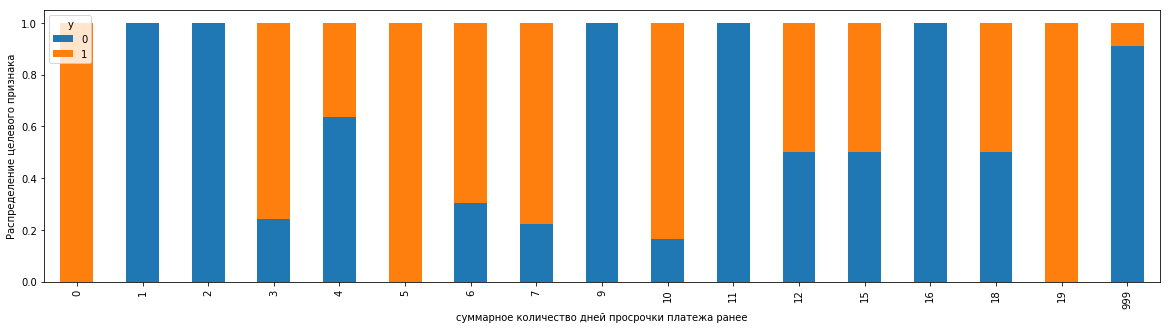

y,0,1
pdays,,
0,0,2
1,2,0
2,3,0
3,10,31
4,7,4
5,0,4
6,10,23
7,2,7
9,1,0


In [344]:
# Стоит заметить, что большая часть данных для этого признака пропущена и закодирована очень большим значением
# Но т.к. мы будем использовать в качестве модели случайный лес, это не должно вызывать какие-либо трудности
# Добавим данный признак в модель и посмотрим, что из этого получится
pdays_table = pd.crosstab(data['pdays'], data['y'])
pdays_table.div(pdays_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('суммарное количество дней просрочки платежа ранее');
plt.ylabel('Распределение целевого признака');
pd.crosstab(data['pdays'], data['y'])

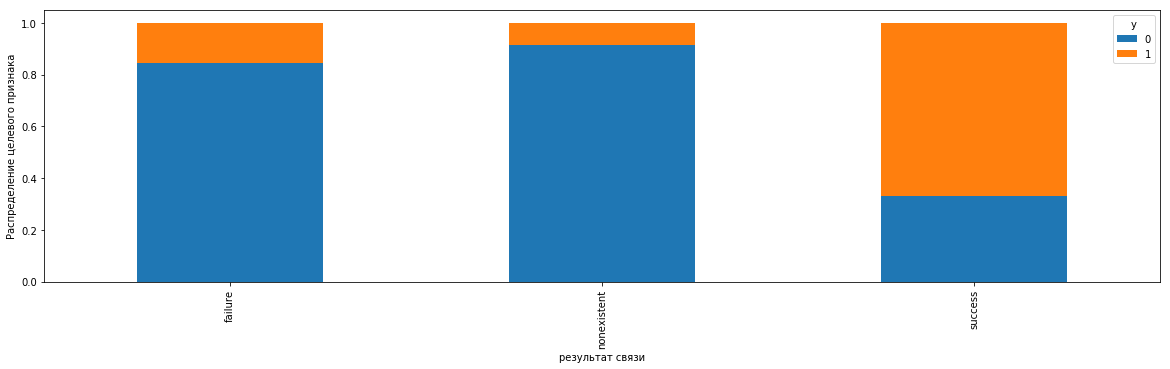

In [346]:
# Определенно стоит добавить данный признак в модель
poutcome_table = pd.crosstab(data['poutcome'], data['y'])
poutcome_table.div(poutcome_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('результат связи');
plt.ylabel('Распределение целевого признака');

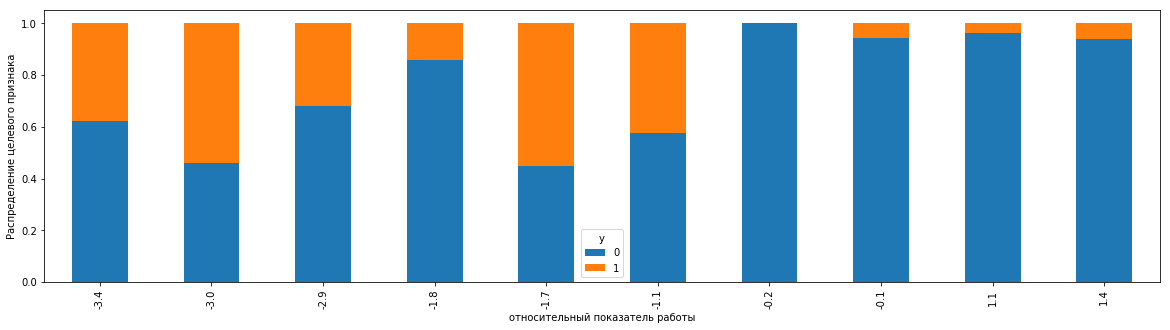

In [348]:
# Все пять последних признаков стоят того, чтобы добавить их в модель
evr_table = pd.crosstab(data['emp.var.rate'], data['y'])
evr_table.div(evr_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('относительный показатель работы');
plt.ylabel('Распределение целевого признака');

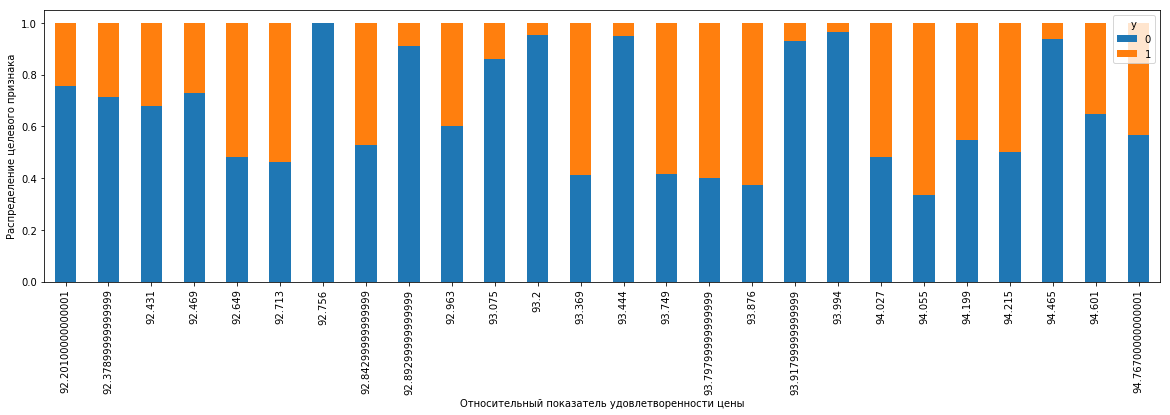

In [349]:
cpi_table = pd.crosstab(data['cons.price.idx'], data['y'])
cpi_table.div(cpi_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Относительный показатель удовлетворенности цены');
plt.ylabel('Распределение целевого признака');

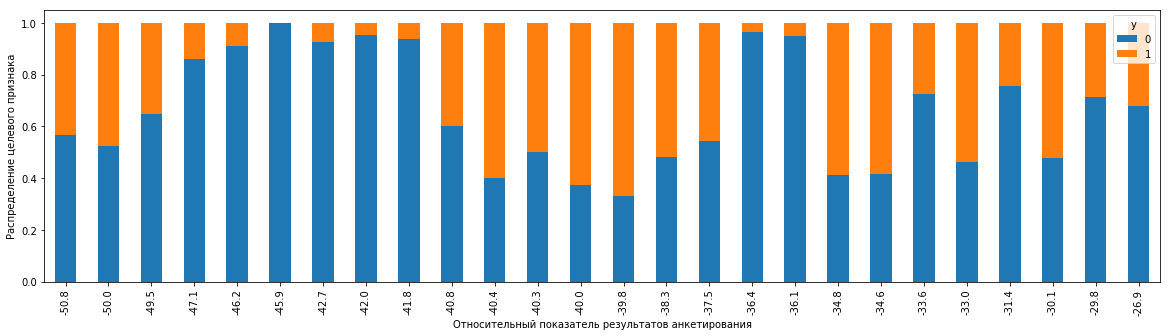

In [354]:
cci_table = pd.crosstab(data['cons.conf.idx'], data['y'])
cci_table.div(cci_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Относительный показатель результатов анкетирования');
plt.ylabel('Распределение целевого признака');

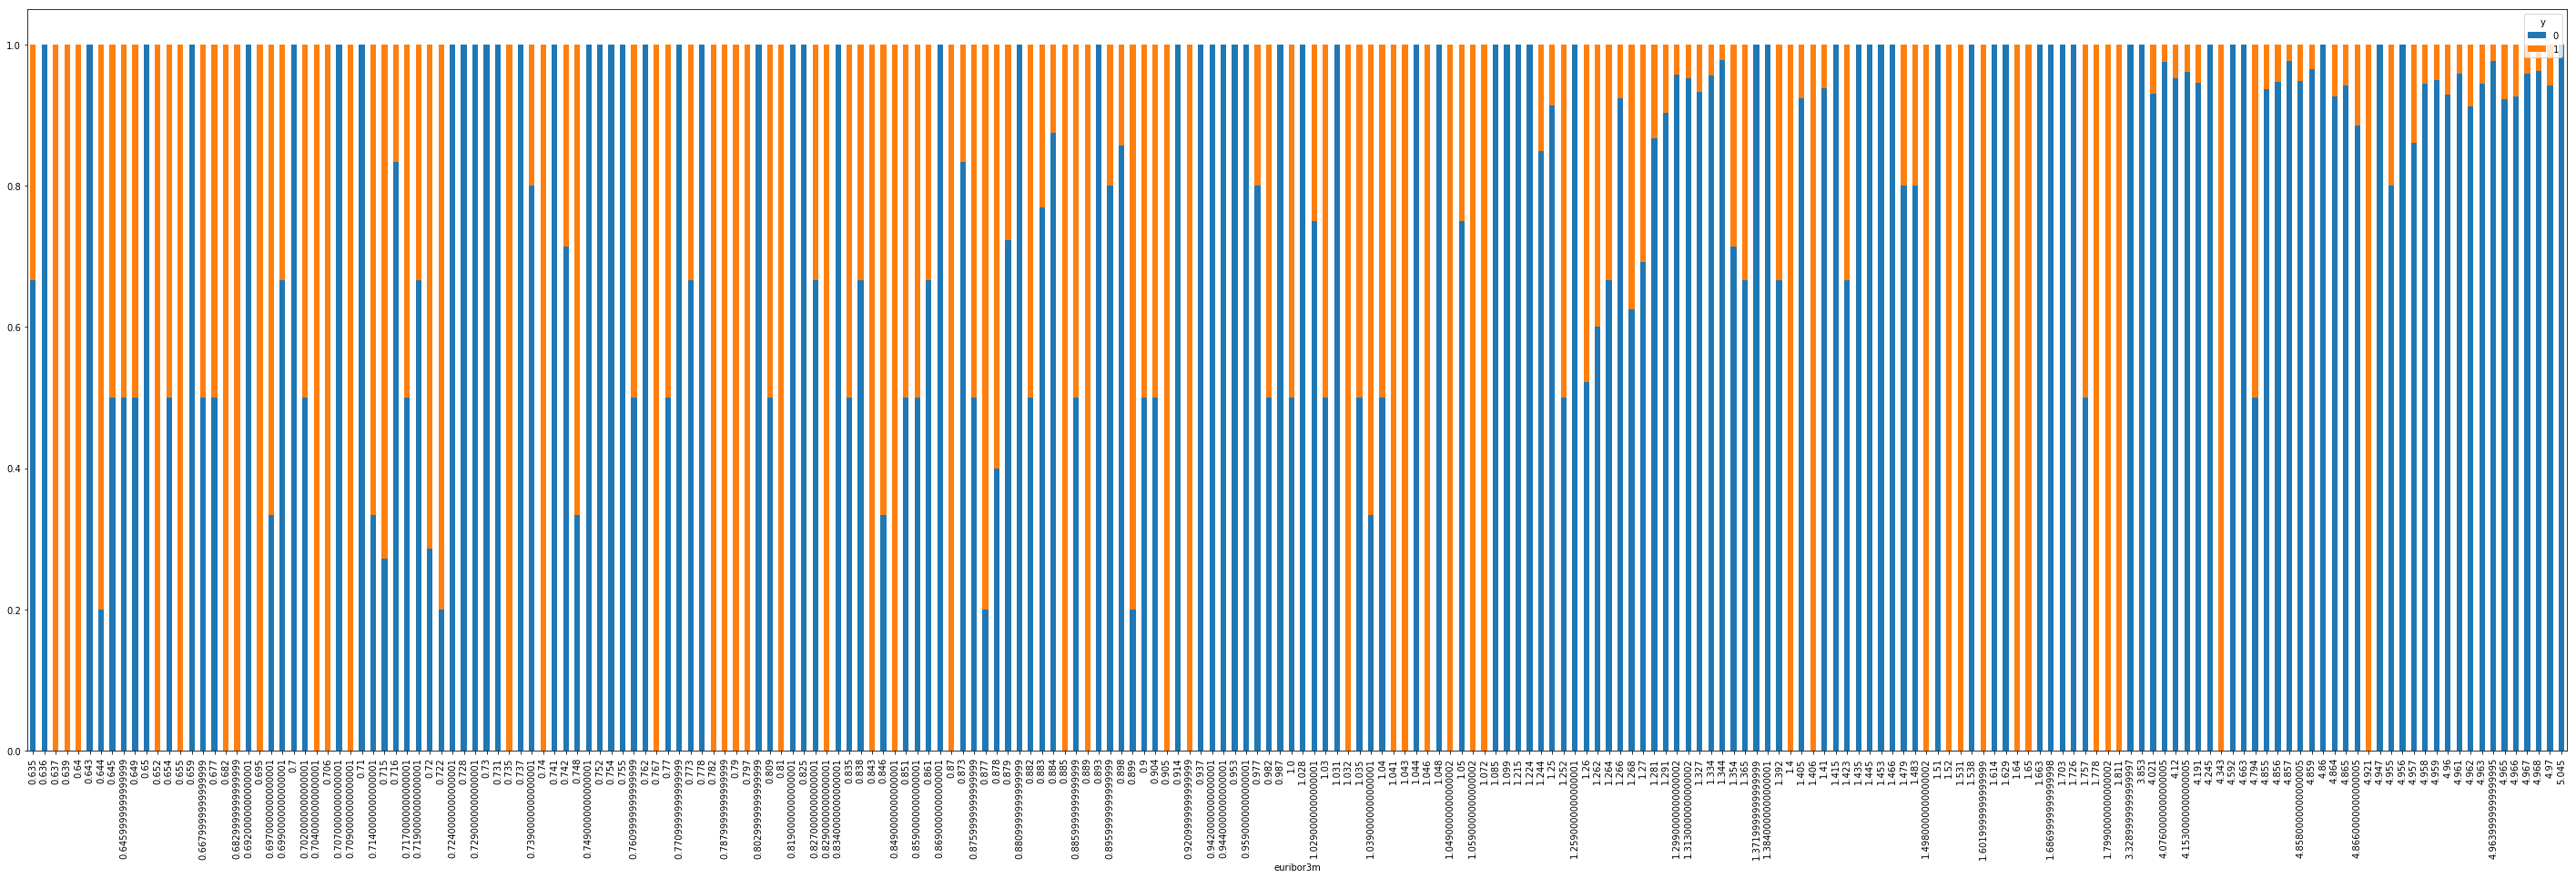

In [365]:
euribor3m_table = pd.crosstab(data['euribor3m'], data['y'])
euribor3m_table.div(euribor3m_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(50, 15));

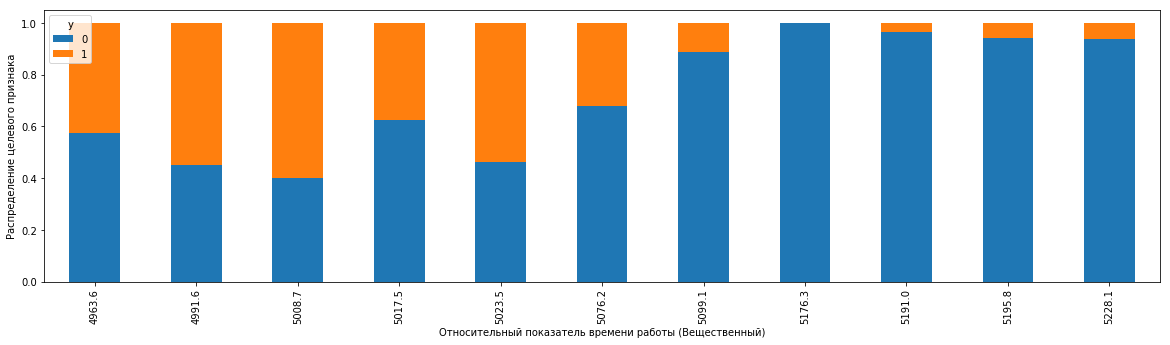

In [366]:
cci_table = pd.crosstab(data['nr.employed'], data['y'])
cci_table.div(cci_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(20, 5));
plt.xlabel('Относительный показатель времени работы (Вещественный)');
plt.ylabel('Распределение целевого признака');

Таким образом мы получили следующие признаки:
1. age
2. job (Необходимо кодировать)
3. duration
4. pdays
5. contact (Необходимо кодировать)
6. month (Необходимо кодировать)
7. campaign
8. poutcome (Необходимо кодировать)
9. emp.var.rate
10. cons.price.idx
11. cons.conf.idx
12. euribor3m
13. nr.employed

Продолжим отбор признаков и посмотрим на их взаимозависимость.

In [376]:
# Построим корреляционную матрицу для последних 5 признаков
columns = ['emp.var.rate',
           'cons.price.idx',
           'cons.conf.idx', 
           'euribor3m',
           'nr.employed']
corr_matrix = data.loc[:, columns].corr()
corr_matrix

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
emp.var.rate,1.000000,0.747513,0.219751,0.969968,0.892328
cons.price.idx,0.747513,1.000000,0.063948,0.645568,0.450870
cons.conf.idx,0.219751,0.063948,1.000000,0.300212,0.130593
euribor3m,0.969968,0.645568,0.300212,1.000000,0.940434
nr.employed,0.892328,0.450870,0.130593,0.940434,1.000000


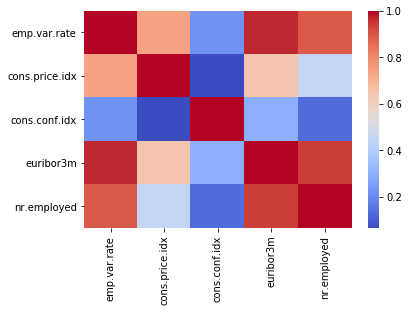

In [377]:
# А также heatmap для наглядности
# Как мы можем наблюдать, cons.conf.idx слабо коррелирует с другими признаками, его мы оставляем сразу
# А среди остальных присутствует сильная линейная корреляция
# Придется оставить среди выбраных признаков nr.employed и cons.price.idx, среди всего этого взаимозависимого набора
# Т.к. они наименее сильно коррелируют с остальными и друг с другом
sns.heatmap(corr_matrix, cmap='coolwarm');

Таким образом мы отобрали для построения модели следующие признаки:
1. age
2. job (Необходимо кодировать)
3. duration
4. pdays
5. contact (Необходимо кодировать)
6. month (Необходимо кодировать)
7. campaign
8. poutcome (Необходимо кодировать)
9. cons.price.idx
10. cons.conf.idx
11. nr.employed

In [430]:
# Отберем нужные признаки и преобразуем категориальные из текста в числа
selected_X = data.loc[:, ['job', 'duration', 'contact', 'month', 'campaign', 'poutcome', 'cons.price.idx', 'cons.conf.idx',
                           'nr.employed','age', 'pdays']]
y = data.loc[:, ['y']]

selected_X['job'], selected_X_categories = selected_X['job'].factorize()
selected_X['contact'], selected_X_categories = selected_X['contact'].factorize()
selected_X['month'], selected_X_categories = selected_X['month'].factorize()
selected_X['poutcome'], selected_X_categories = selected_X['poutcome'].factorize()

selected_X.head()

,job,duration,contact,month,campaign,poutcome,cons.price.idx,cons.conf.idx,nr.employed,age,pdays
0,0,487,0,0,2,0,92.893,-46.2,5099.1,30,999
1,1,346,1,0,4,0,93.994,-36.4,5191.0,39,999
2,1,227,1,1,1,0,94.465,-41.8,5228.1,25,999
3,1,17,1,1,3,0,94.465,-41.8,5228.1,38,999
4,2,58,0,2,1,0,93.200,-42.0,5195.8,47,999


In [479]:
# Для кросс-валидации
cross_val = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

# Наш случайный лес
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

# Переменные для оценок точности
aucs = []
mean_auc = 0

for train_index, test_index in cross_val.split(selected_X, y):
    classifier.fit(selected_X.iloc[train_index], y.iloc[train_index].values.ravel())  
    pred_labels = classifier.predict(selected_X.iloc[test_index])
    roc_auc_rf = metrics.roc_auc_score(y.iloc[test_index], pred_labels)
    aucs.append(roc_auc_rf)
    mean_auc += roc_auc_rf
    
print(aucs)
print('Среднее значение по 5 фолдам: ', mean_auc/5)


[0.8801191163576485, 0.8548523342101324, 0.9053110498064626, 0.8605301426402345, 0.8647590941168923]
Среднее значение по 5 фолдам:  0.873114347426274


3-5 действий по итогу оценки качества, которые еще можно было бы сделать:
* В наших данных присутствуют категориальные признаки, которые могут зависеть друг от друга. Мы бы могли проверить зависимость между ними с помощью корреляции мэтьюса.
* Мы закодировали категориальные принаки просто при помощи цифр, но могли бы использовать One-hot кодирование и сравнить результаты.
* Можно было провести качественную работу по выбору оптимального числа деревьев и максимальной глубины нашего случайного леса.
* Хотя модель случайного леса практически нечувствительна к выбросам, можно было провести работу по очистке исходной выборки.
* Можно было использовать вместо модели не только случайный лес, но и например, SVM.